In [253]:
'''
This is a sandbox to work on proving that we can get digital 
sound out of scans of an optical track. If I can manually 
get it to work here, I can then take this PoC and turn it into
a full application.
'''
import cv2
import os
import matplotlib.pyplot as plt
import math
import numpy as np
import wave
import struct
import natsort
from scipy.io import wavfile
from scipy.signal import butter, lfilter

In [254]:
imagefiles = natsort.natsorted(os.listdir("./examples/fulltest/"))
print(len(imagefiles))
DURRATION = len(imagefiles) / 24
CUTTOFF_FREQUENCY = 16000
S_INT16_MAX = 32767


288


In [255]:
images = []
cutoff = 0
for filename in imagefiles:
    # if cutoff > 1:
    #     break

    img = cv2.imread("examples/fulltest/" + filename, cv2.IMREAD_GRAYSCALE)
    height,width = img.shape
    img = img[round((2390+2270)/2):height-350, 800:width-1100] # average of bottom of frame and top of audio
    
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Default reads in as BGR, we want this as black and white
    #img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    
    # # Adjusts the brightness by adding 10 to each pixel value 
    # brightness = 5
    # # Adjusts the contrast by scaling the pixel values by 2.3 
    # contrast = 3 
    # img = cv2.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness) 

    # Create the sharpening kernel
    # kernel = np.array([[-1,-1,-1], 
    #                    [-1,9,-1], 
    #                    [-1,-1,-1]])
    # Apply the sharpening kernel to the image using filter2D
    #img = cv2.filter2D(img, -1, kernel)

    # height,width = img.shape
    #img = img[700:height-1000,400:width-2000]

    # This is to trim this exact scan images so that the end of the frames ~perfectly go into the nex
    #img = img[965:height-1255,500:width-1000]
    
    # Rotate back
    # img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Make pixel 1 or 0, "thresholding". This is how we make the optical track either black or white
    ret,threshold = cv2.threshold(img,128,255,cv2.THRESH_BINARY) # invert so white = 255, black = 0
    
    # rabbit hole of detecting the central frame for image extraction and audo position selection. Maybe classifiers? https://www.geeksforgeeks.org/detect-an-object-with-opencv-python/
    # contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    # for _id, contour in enumerate(contours):
    #     approx = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, True), True)
    #     if len(approx)>=4:# and cv2.arcLength(contour, True)>100:
    #         cv2.drawContours(img, contours, _id, (255, 255, 255), 20)
    # plt.imshow(img)
    
    # plt.imshow(threshold, cmap='gray')
    images.append(threshold)
    cutoff = cutoff + 1
num_images = len(images)

images = images[::-1] # Reverse the list order to get the expected order of the optical tracks


# plt.figure(figsize=[30,20])
# for i in range(0, num_images):
#     plt.subplot(num_images, 1, i+1)
#     plt.axis('off')
#     plt.imshow(images[i], cmap='gray') # matplot reads the channels as RGB, so we need to tell it this is actually grey or we get weird channel issues


## Visualize the crop is correct by concatinating the two images

True

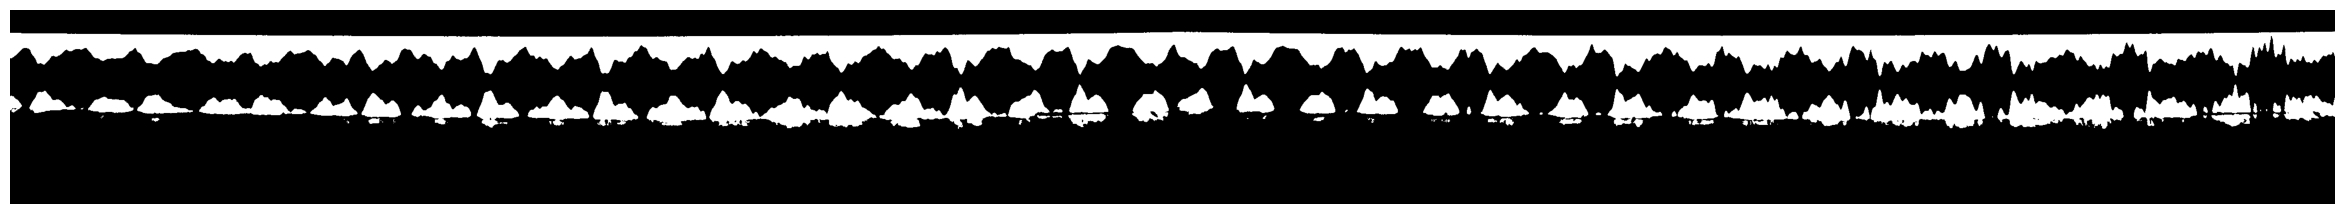

In [256]:
# Concatinated image to show merge visually
merged_images = cv2.hconcat(images[0:2])
plt.figure(figsize=[30,10])
plt.subplot(1, 1, 1)
plt.axis('off')
plt.imshow(merged_images, cmap='gray')
cv2.imwrite("mergedDemo.jpeg",merged_images)

## Get just the soundtrack, get mean values per row and convert to sint_16

In [257]:
### Another Method, not mean but only look at white pixels

sound_only_imgs = images.copy()
frame_sounds = []

for sound_only_img in sound_only_imgs:  # this whole section is heniously slow. please fix.
    
    #find start of white of the audio track
    x = []
    y = []
    height,width = sound_only_img.shape
    for column in range(width):
        for row in range(height):
            if sound_only_img[row, column] == 255:
                x.append(column)
                y.append(row)
                break
    #find function for the start
    from scipy import stats
    slope, intercept, r, p, std_err = stats.linregress(x, y)
    # print(slope) # should be almost 0
    def get_start(x):
        return max(round(x*slope+intercept)-60, 0)  # start 60 pixels before the line to not miss the start as it is more important than the peaks
    def get_end(x):
        return min(round(x*slope+intercept)+85, height)  # end 65 pixels after the line as that is the center of the strip
    # # for testing line
    # preview = sound_only_img.copy()
    # cv2.line(preview, (0,get_end(0)), (width,get_end(width)), color=255, thickness=1)
    # cv2.line(preview, (0,get_end(0)-1), (width,get_end(width)-1), color=0, thickness=1)
    # plt.imshow(preview)
    
    #scan image from start position predicted by linear regression for the standard ? pixels
    frame_sound = []
    for column in range(width):
        column_amplitude = 0
        for row in range(get_start(column), get_end(column)+1):
            if sound_only_img[row, column] == 255:
                column_amplitude += 1
        frame_sound.append(column_amplitude)
    # # for testing line
    # preview = sound_only_img.copy()
    # for i in range(width-1):
    #     cv2.line(preview, (i,25+frame_sound[i]), (i+1,25+frame_sound[i+1]), color=(0,0,128), thickness=1)  # 25 is arbitrary so the trace shows up
    # plt.imshow(preview)
    frame_sounds.extend(frame_sound)
    

-0.0004849572955295604
2156 2156
-0.000327137903726387
2156 2156
0.002400117445791478
2156 2156
0.0016323317165394522
2156 2156
0.0016378215340408398
2156 2156
0.000866382397465186
2156 2156
0.009319456655443122
2156 2156
0.0035625589569566753
2156 2156
-0.003921666942435208
2156 2156
-0.0029628252012027217
2156 2156
-0.0029325103187495386
2156 2156
-0.0028873951161793397
2156 2156
0.005151969011456487
2156 2156
-0.0039049565375024638
2156 2156
0.0016544100885821397
2156 2156
0.009784871741376442
2156 2156
0.009625476001214465
2156 2156
-0.001184881143419292
2156 2156
-0.003412497853456667
2156 2156
0.0024487342469403334
2156 2156
0.0013012134197000855
2156 2156
0.00143964350009556
2156 2156
-0.004631308196409619
2156 2156
-0.005832115205102676
2156 2156
1.9489892038726207e-05
2156 2156
0.0014708600160626068
2156 2156
0.0010915932068344709
2156 2156
0.009933174232109073
2156 2156
0.0013409646401211603
2156 2156
0.0029571525543877738
2156 2156
-0.0017729150262319976
2156 2156
-0.0025297

<Figure size 3000x1000 with 0 Axes>

In [310]:
# need to shift and normalize amplitude data
mean_value = round(np.mean(frame_sounds))
amplitude_max = max(frame_sounds)
amplitude_min = min(frame_sounds)
amplitude_range = amplitude_max -amplitude_min
factor = math.floor((S_INT16_MAX*2+1)/amplitude_range)
centered_frame_sounds = map(lambda x:int(factor*(x-amplitude_range/2)), frame_sounds[::-1])  # fix the reverse audio issue
print(mean_value, amplitude_range, factor)
#print(max(centered_frame_sounds))

31 97 675


## Write to a WAV file

In [311]:
sample_rate = 1836 * 24 # Currently making the sample rate the height of each image times the amount of frames in a second
print(f"Sample rate: { sample_rate }")
duration = DURRATION # Length in seconds
num_channels = 1
bit_depth = 16 # sint_16 type
num_frames = int(sample_rate * duration) # amount of frames in a second
samp_per_frame = 1836
raw_output_file = 'output.wav'
filtered_output_file = 'outputFilter.wav'

with wave.open(raw_output_file, 'wb') as output_file:
    output_file.setnchannels(num_channels)
    output_file.setsampwidth(bit_depth // 8)
    output_file.setframerate(sample_rate)
    output_file.setnframes(num_frames)
    output_file.setcomptype('NONE', 'Not Compressed')
    for sample in centered_frame_sounds:
        if not ((-0x7fff - 1) <= sample <= 0x7fff):
            print(sample)
        packed_sample = struct.pack('<h', sample)
        output_file.writeframesraw(packed_sample)



Sample rate: 44064


### Filtering frequenices out of the audio

In [58]:
def high_pass_filter(data, cutoff_frequency, sample_rate, order=5):
    b, a = butter(order, cutoff_frequency / (sample_rate / 2), btype='high')
    filtered_data = lfilter(b, a, data)
    return filtered_data

def low_pass_filter(data, cutoff_frequency, sample_rate, order=5):
    b, a = butter(order, cutoff_frequency / (sample_rate / 2), btype='low')
    filtered_data = lfilter(b, a, data)
    return filtered_data

read_rate, read_audio_data = wavfile.read(raw_output_file)
print(read_rate)

filtered_audio = low_pass_filter(read_audio_data, CUTTOFF_FREQUENCY, read_rate)

# Apply the high-pass filter to our audio data
# filtered_audio = high_pass_filter(read_audio_data, 16000, read_rate)


wavfile.write(filtered_output_file, read_rate, filtered_audio)

44064


# That's it! It might sound bad, but it is converted